In [507]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import CountEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Часть 1

In [508]:
data = pd.read_csv("german_credit_data.csv", index_col=0, delimiter=",")

In [509]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [510]:
data.describe(include="all")

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
count,1000.000000,1000,1000.000000,1000,817,606,1000.000000,1000.000000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8
top,NaN,male,NaN,own,little,little,NaN,NaN,car
freq,NaN,690,NaN,713,603,274,NaN,NaN,337
mean,35.546000,NaN,1.904000,NaN,NaN,NaN,3271.258000,20.903000,NaN
std,11.375469,NaN,0.653614,NaN,NaN,NaN,2822.736876,12.058814,NaN
min,19.000000,NaN,0.000000,NaN,NaN,NaN,250.000000,4.000000,NaN
25%,27.000000,NaN,2.000000,NaN,NaN,NaN,1365.500000,12.000000,NaN
50%,33.000000,NaN,2.000000,NaN,NaN,NaN,2319.500000,18.000000,NaN
75%,42.000000,NaN,2.000000,NaN,NaN,NaN,3972.250000,24.000000,NaN


In [511]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


#### Посмотрим уникальные значения признаков "Housing", "Saving accounts", "Checking account" и "Purpose"

In [512]:
for column in ["Housing", "Saving accounts", "Checking account", "Purpose"]:
    print(f'{column}: {data[column].unique()}')

Housing: ['own' 'free' 'rent']
Saving accounts: [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account: ['little' 'moderate' nan 'rich']
Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


In [513]:
data = data.fillna("NA")

#### Признак "Sex" закодируем с помощью OrdinalEncoder по умолчанию. Признаки "Saving accounts" и "Checking account" закодируем с помощью OrdinalEncoder, учитывая значимость их значений; после чего "0" заменим на "-999". Признаки "Housing" и "Purpose" закодируем по частоте с помощью CountEncoder.

In [514]:
data_encoded = pd.DataFrame()
data_encoded = data[["Age", "Job", "Credit amount", "Duration"]]
encoder = OrdinalEncoder()
# data_encoded[["Sex", "Saving accounts", "Checking account", "Housing", "Purpose"]] = encoder.fit_transform(data[["Sex", "Saving accounts", "Checking account", "Housing", "Purpose"]])
data_encoded["Sex"] = encoder.fit_transform(data[["Sex"]])
saving_acc = ["NA", "little", "moderate", "quite rich", "rich"]
checkinc_acc = ["NA", "little", "moderate", "rich"]
encoder = OrdinalEncoder(categories=[saving_acc])
data_encoded["Saving accounts"] = encoder.fit_transform(data[["Saving accounts"]])
data_encoded["Saving accounts"] = data_encoded["Saving accounts"].apply(lambda x: -999 if x == 0.0 else x)
encoder = OrdinalEncoder(categories=[checkinc_acc])
data_encoded["Checking account"] = encoder.fit_transform(data[["Checking account"]])
data_encoded["Checking account"] = data_encoded["Checking account"].apply(lambda x: -999 if x == 0.0 else x)
encoder = CountEncoder()
data_encoded[["Housing", "Purpose"]] = encoder.fit_transform(data[["Housing", "Purpose"]])

/var/folders/bn/hsybgd4s06g02xc7n0k2znn40000gn/T/ipykernel_21149/2798795132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_encoded["Sex"] = encoder.fit_transform(data[["Sex"]])
/var/folders/bn/hsybgd4s06g02xc7n0k2znn40000gn/T/ipykernel_21149/2798795132.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_encoded["Saving accounts"] = encoder.fit_transform(data[["Saving accounts"]])
/var/folders/bn/hsybgd4s06g02xc7n0k2znn40000gn/T/ipykernel_21149/2798795132.py:10: SettingWithCopyWarning: 
A valu

In [515]:
data_encoded.head()

,Age,Job,Credit amount,Duration,Sex,Saving accounts,Checking account,Housing,Purpose
0,67,2,1169,6,1.0,-999.0,1.0,713,280
1,22,2,5951,48,0.0,1.0,2.0,713,280
2,49,1,2096,12,1.0,1.0,-999.0,713,59
3,45,2,7882,42,1.0,1.0,1.0,108,181
4,53,2,4870,24,1.0,1.0,1.0,108,337


#### Посмотрим на боксплоты наших признаков

<Axes: >

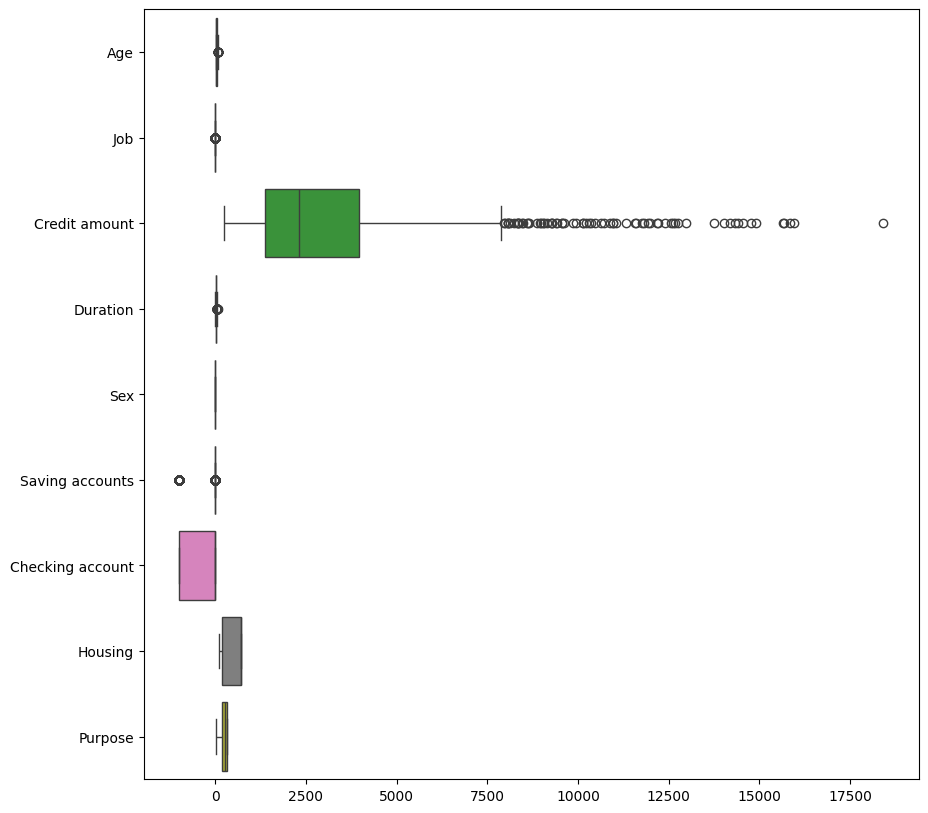

In [516]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=data_encoded, orient="h")

#### Данные имеют значения разных порядков, поэтому нобходимо их нормализовать, чтобы признаки с более высоким порядком не имели больший вес, т.к будет рассчитваться Евклидово расстояние и оно будет больше у признакаов сс большим порядком.

In [517]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)

#### Посмотрим на распределение признаков

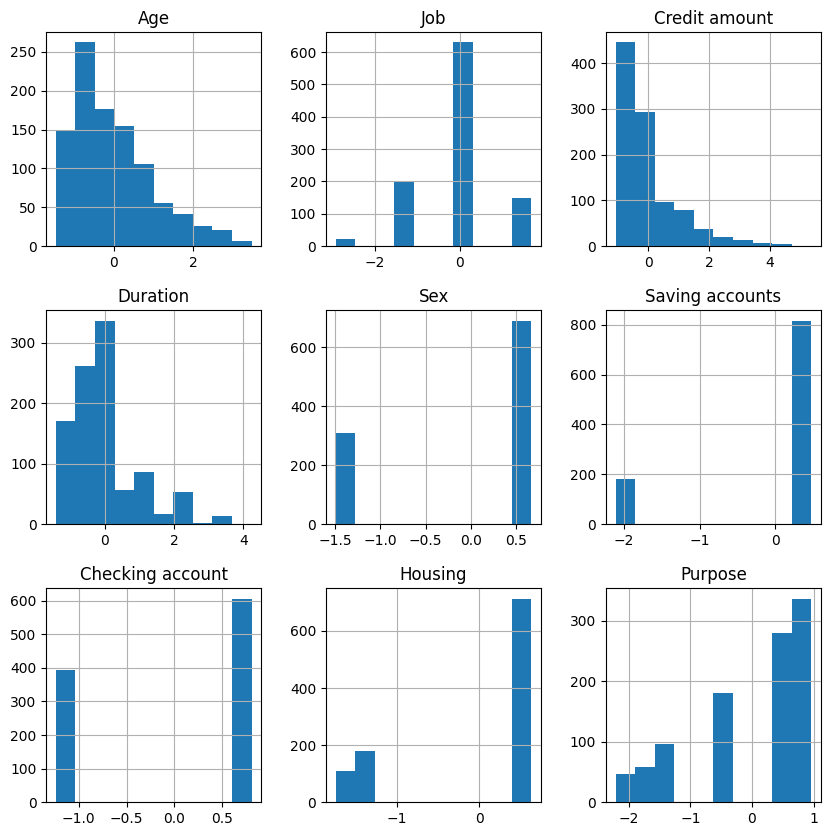

In [518]:
data_scaled.hist(figsize=(10,10));

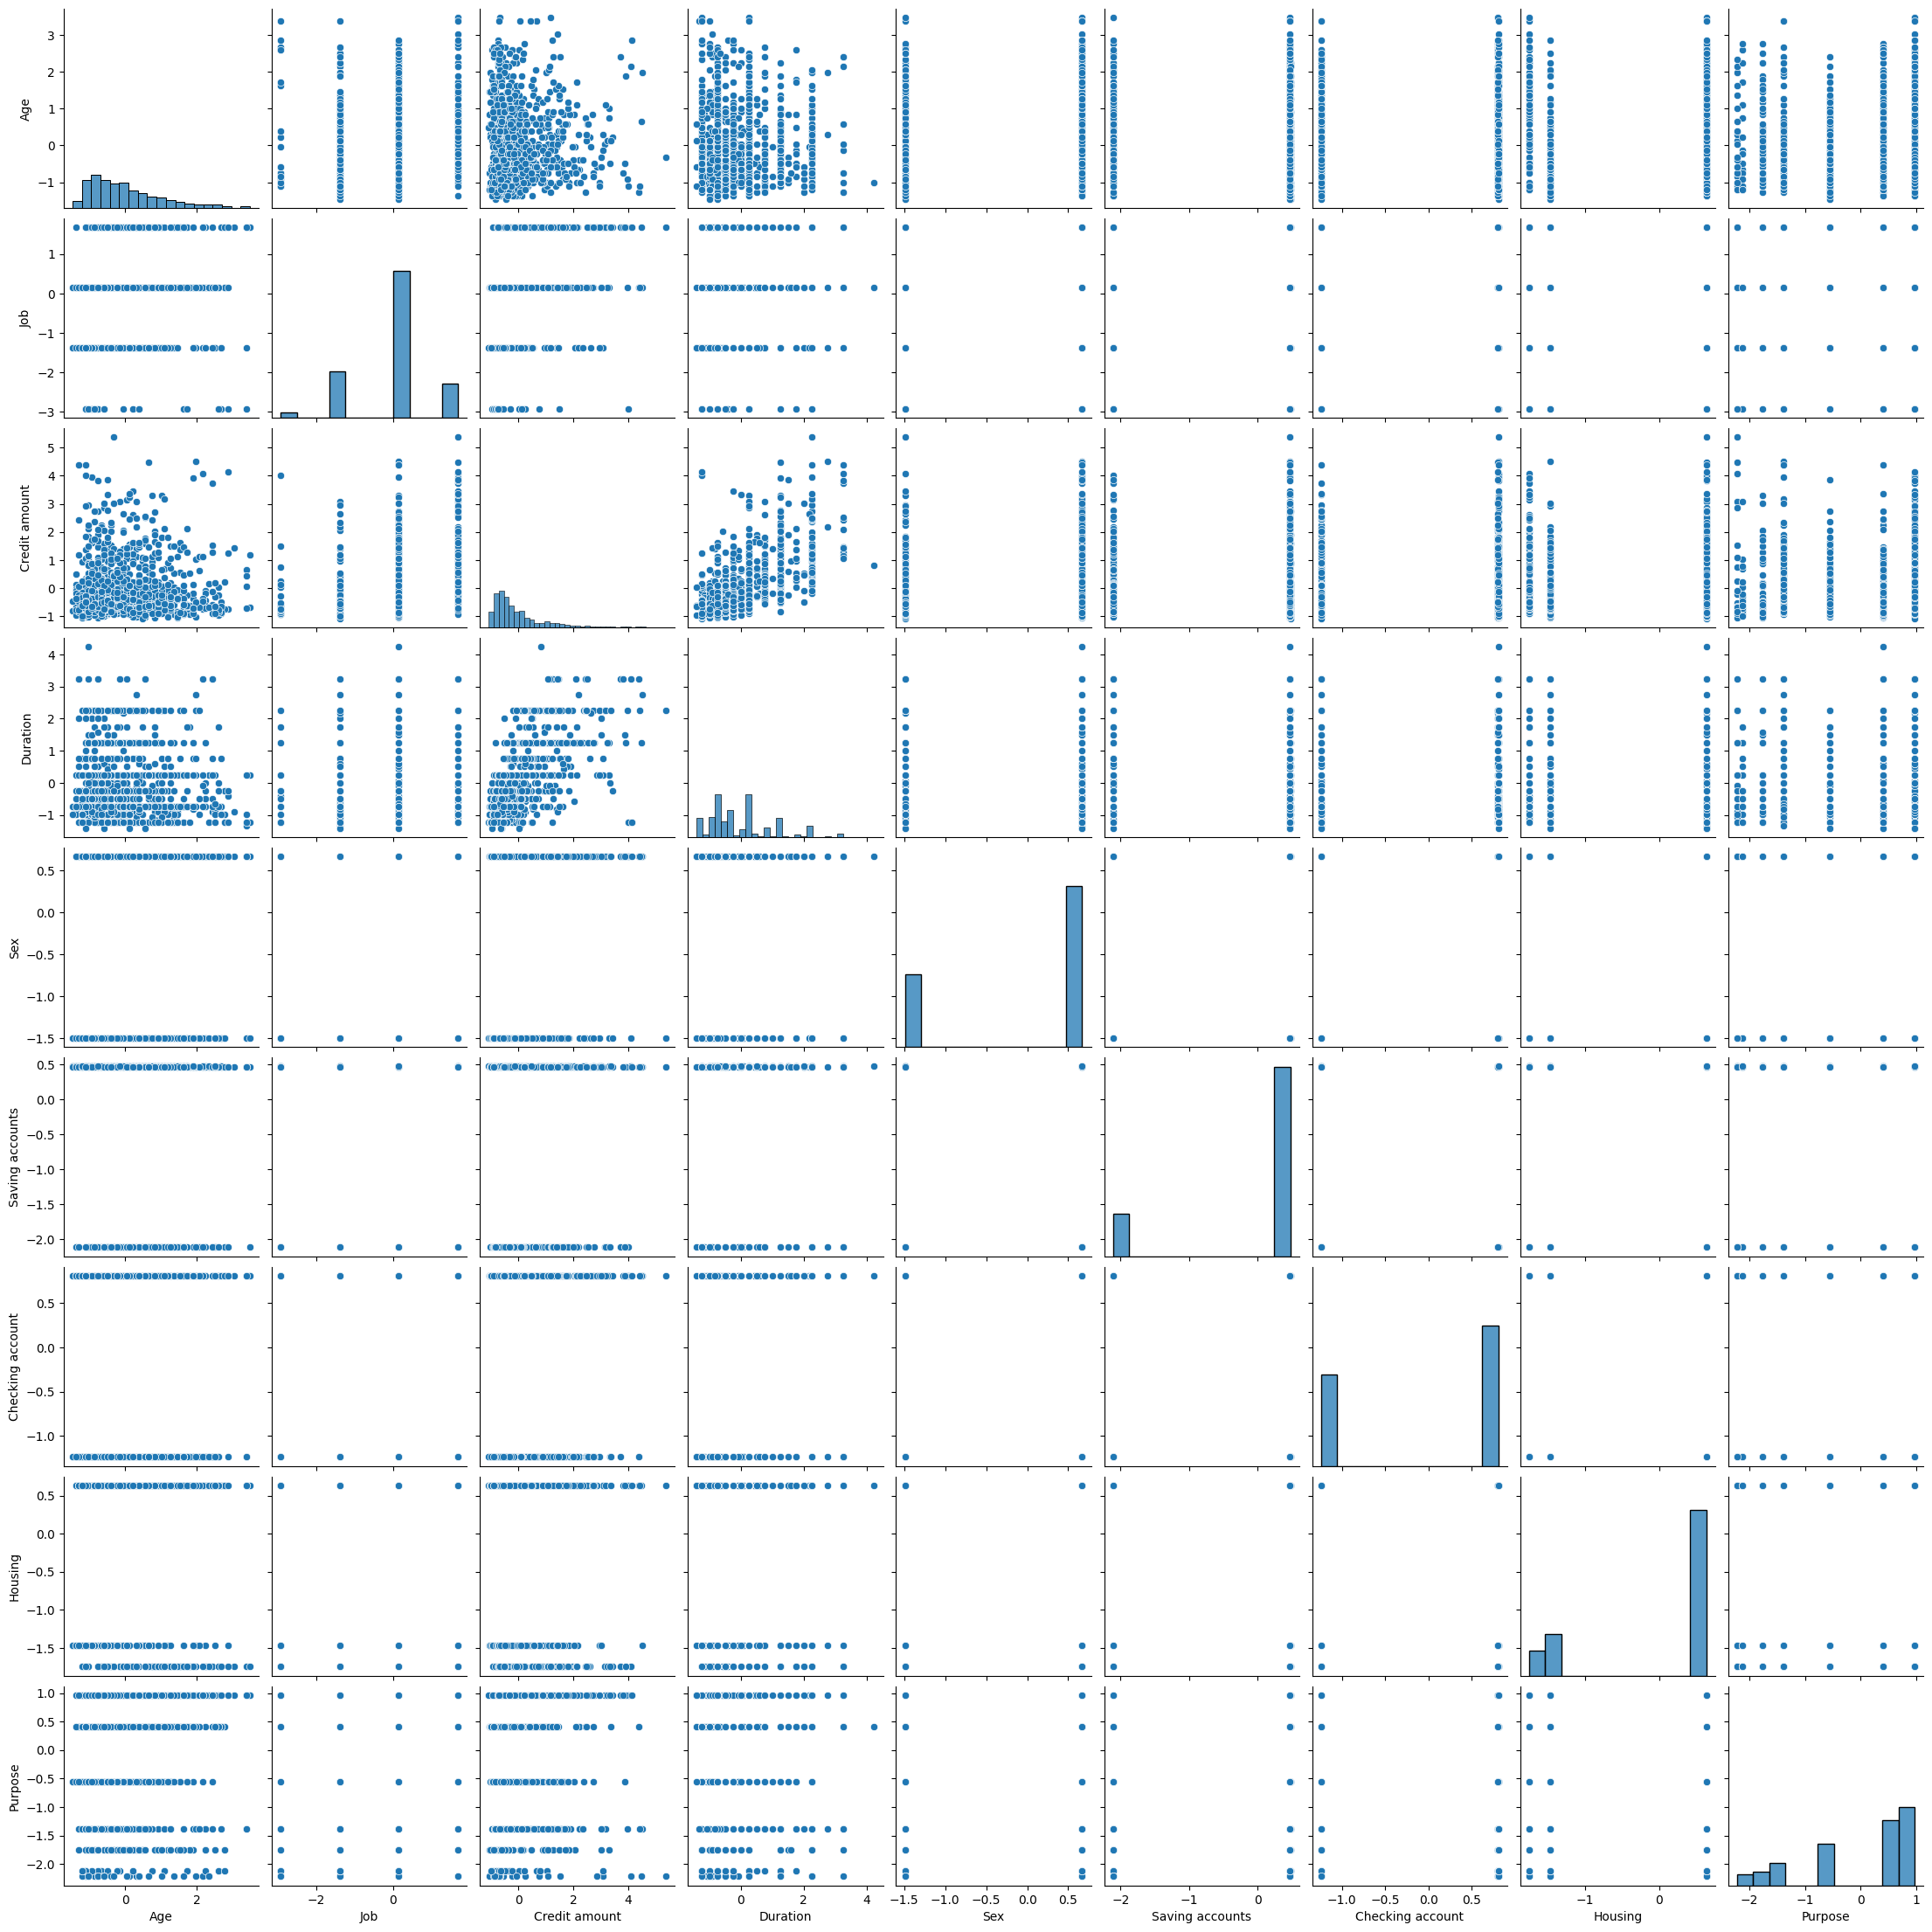

In [519]:
sns.pairplot(data_scaled);

#### Посмотрим также на корреляцию

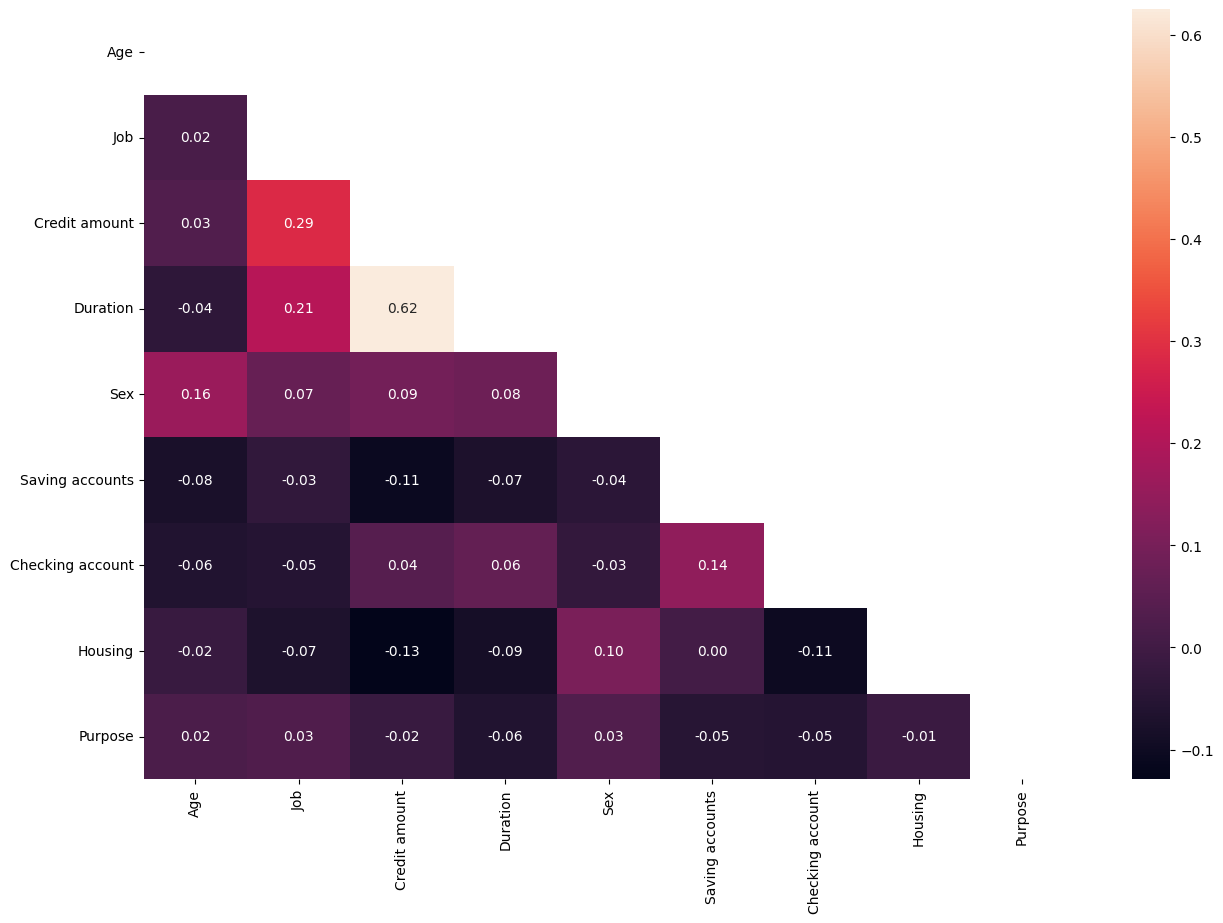

In [520]:
corr = data_scaled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f');

# Часть 2

#### Уменьшим размеррность и визуализируем наши данные

In [521]:
dimensity_encoder = TSNE(n_components=2, random_state=42)   # показался лучшим, оставил его
# dimensity_encoder = PCA(n_components=2, random_state=42)
# dimensity_encoder = umap.UMAP()
data_tsne = dimensity_encoder.fit_transform(data_scaled)

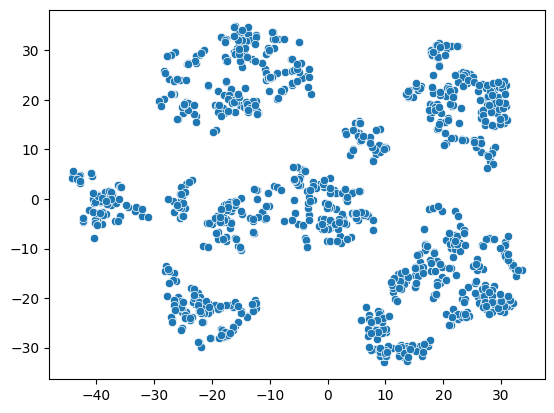

In [522]:
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1]);

#### Визуально можно выделить 6 "глобальных" кластеров, или порядка 20 более чатных кластеров. Поэтому будем выбирать в диапазоне 1-20

In [523]:
def elbow(data):
    inertia = []
    for i in range(1,21):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(data)
        inertia_i = kmeans.inertia_
        inertia.append(inertia_i)
        
    # plt.plot(range(1,21), inertia, marker='o');

    D = []
    for i in range(1,19):
        Di = (inertia[i] - inertia[i+1])/(inertia[i-1] - inertia[i])
        D.append(Di)

    # plt.plot(range(2,20), D, marker='o');
    return inertia, D

## KMeans

In [524]:
inertia, D = elbow(data_scaled)

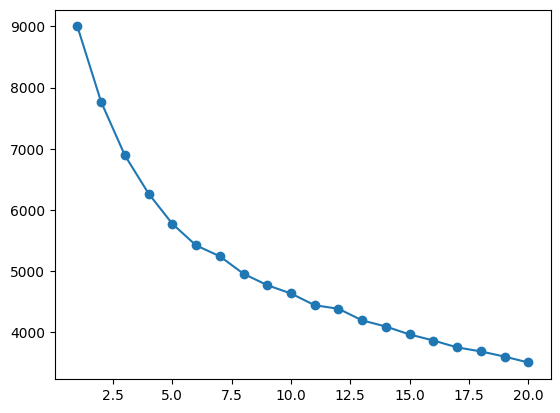

In [525]:
plt.plot(range(1,21), inertia, marker='o');

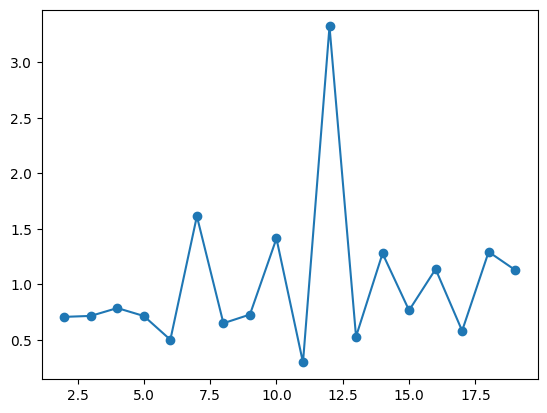

In [526]:
plt.plot(range(2,20), D, marker='o');

#### Судя по графику ф-ии потерь лушим выбором кол-ва кластеров будет 11 и 6. Попробуем визуализировать оба случая и посмоотреть.

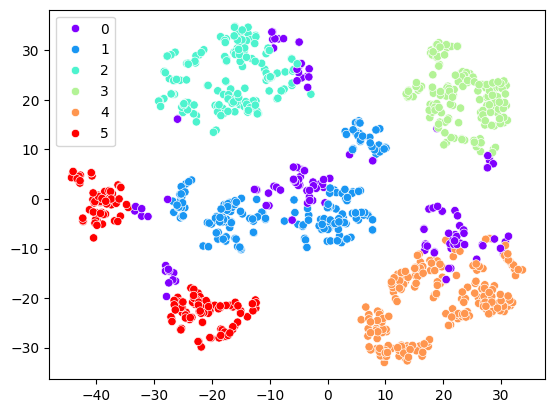

In [527]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10).fit(data_scaled)
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=kmeans.labels_, palette="rainbow");

#### Я решил остановиться на 6 кластерах, визуально это выглядит наиболее верно.

## AgglomerativeClustering (Hierarhical)

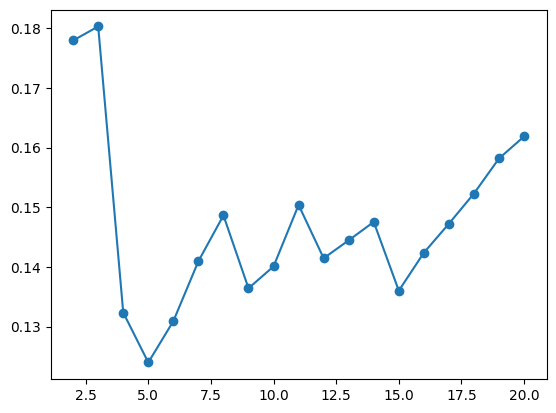

In [528]:
silhouette = []
for i in range(2,21):
    agg = AgglomerativeClustering(n_clusters=i).fit(data_scaled)
    labels = agg.labels_
    score = silhouette_score(data_scaled, labels)
    silhouette.append(score)
plt.plot(range(2,21), silhouette, marker='o');

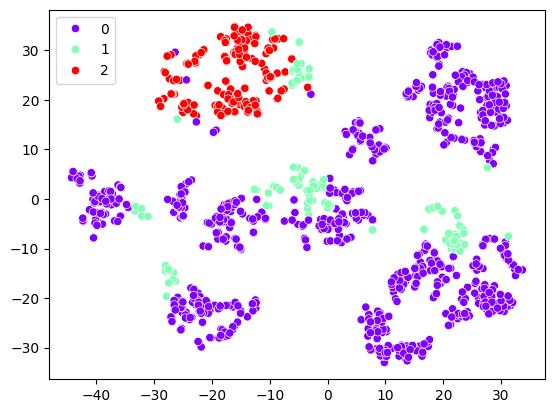

In [529]:
agg = AgglomerativeClustering(n_clusters=3).fit(data_scaled)
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=agg.labels_, palette="rainbow");

#### Судя по графику коэффициента silhouette_score оптимальное кол-во кластеров - 3

## DBSCAN

In [530]:
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in eps_range:
        dbscan = DBSCAN(eps=i, min_samples=5).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

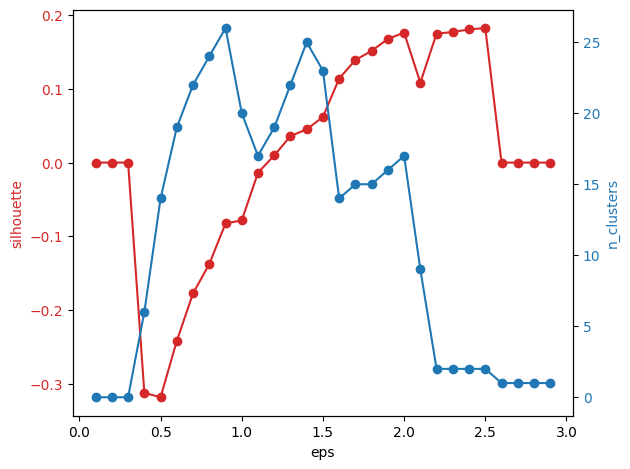

In [531]:
eps_range = np.arange(0.1,3.0,0.1)
dbscan_clustering(eps_range, data_scaled)

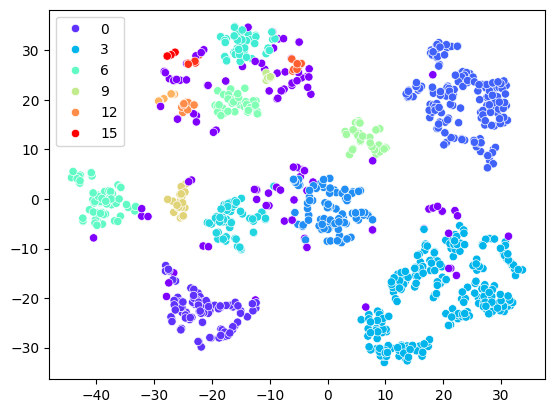

In [532]:
dbscan = DBSCAN(eps=1.9, min_samples=5).fit(data_scaled)
sns.scatterplot(x=data_tsne[:,0], y=data_tsne[:,1], hue=dbscan.labels_, palette="rainbow");

# Часть 3

In [533]:
data["labels"] = kmeans.labels_

In [534]:
data[["Age", "Job", "Credit amount", "Duration", "labels"]].groupby('labels').median().T.round(2)

labels,0,1,2,3,4,5
Age,33.0,29.5,36.0,35.0,33.0,29.0
Job,2.0,2.0,2.0,2.0,2.0,2.0
Credit amount,7882.0,2123.0,2425.5,2155.5,1916.0,1538.0
Duration,42.0,15.0,18.0,18.0,15.0,15.0


#### За основу я взял результат алгоритма KMeans. В полученных кластерах есть следующие закономерности:
1. Чем больше сумма кредита, тем больше срок
2. Вообще берут кредит люди в молодом и среднем возрасте
3. В среднем чуть более взрослые люди берут кредит на более длинный срок
4. Кредиты чаще берут люди имеющие квалификацию

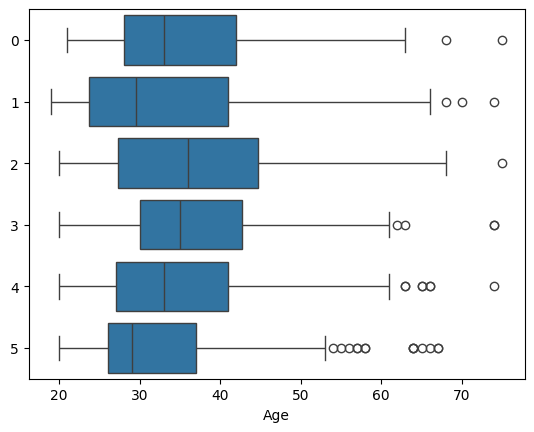

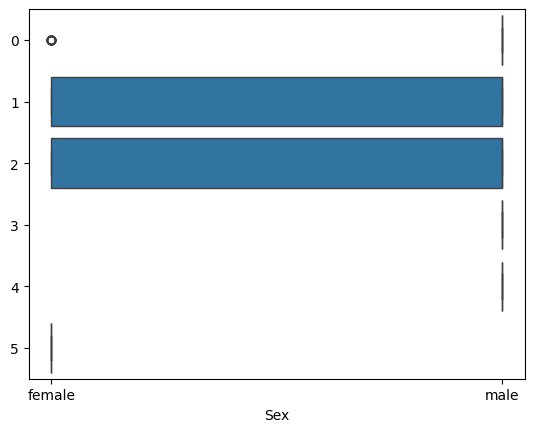

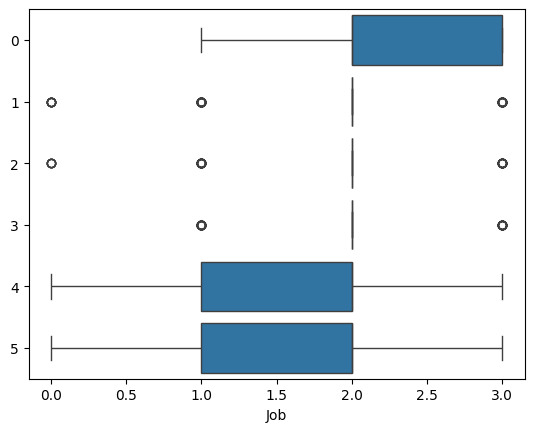

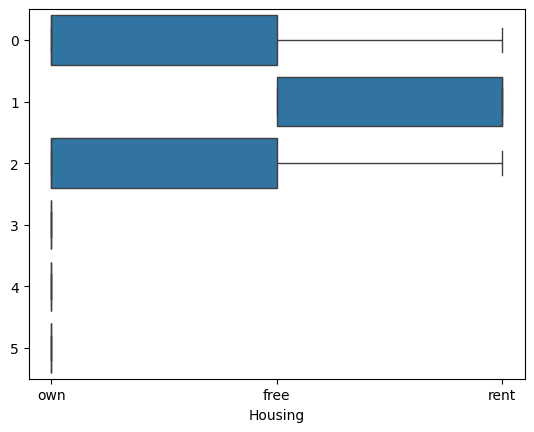

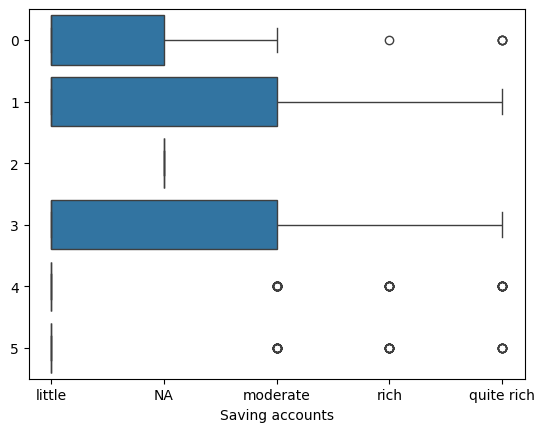

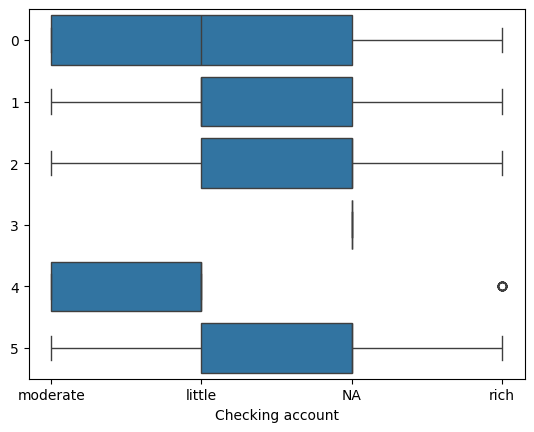

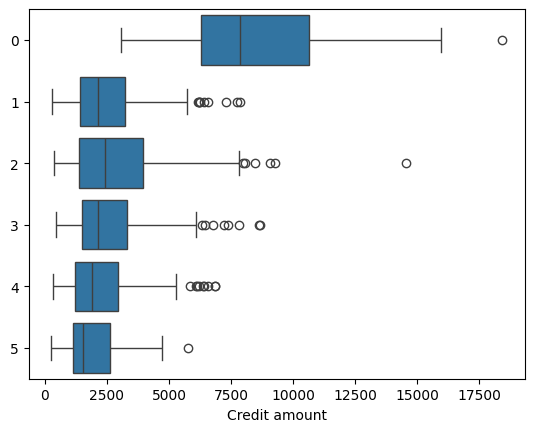

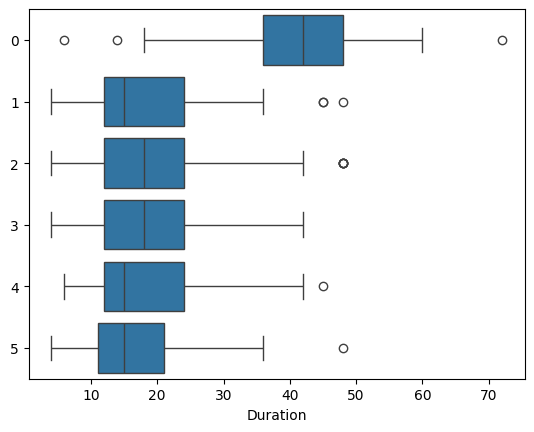

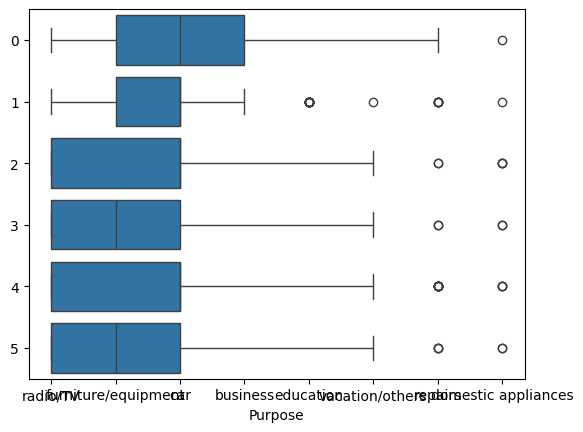

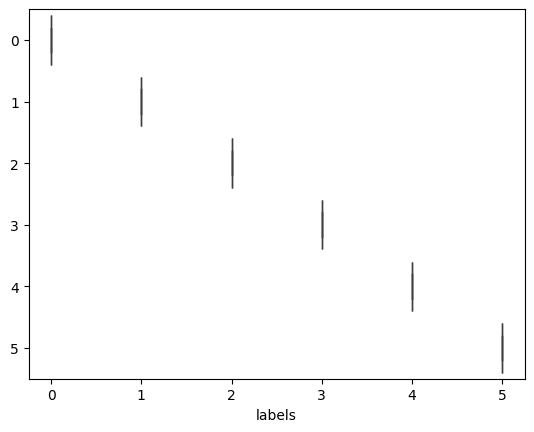

In [535]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=kmeans.labels_, orient='h')
    plt.show();

#### Судя по боксплотам, кластеры лучше всего определяются по следующим признакам: тип квалификации, тип владения жильём, а также срок и размер кредита. Также видно, что кредиты чаще берут мужчины.